In [1]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

Se cargan los datasets.

In [2]:
metadata_original = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features_original = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis_original = pd.read_csv('../data/audio_analysis.csv', index_col='id')

Se seleccionan únicamente las variables numéricas

In [3]:
audio_features = audio_features_original[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

In [4]:
audio_features.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
dtype: object

In [74]:
audio_features.shape

(2206, 13)

# Experiencia 1: KMeans

Primero se hace una prueba con un k = 5, para ir entrando en confianza con las librerías.

In [75]:
audio_features_kmeans5 = KMeans(n_clusters = 5, random_state = 0).fit(audio_features)
audio_features_kmeans5.labels_

array([0, 0, 4, ..., 4, 4, 3], dtype=int32)

In [76]:
# Se calcula el silhouette promedio
silhouette_avg = silhouette_score(audio_features, audio_features_kmeans5.labels_)
silhouette_avg

0.5411973992224247

In [77]:
# Se calcula el silhouette de cada observación
sample_silhouette_values = silhouette_samples(audio_features, audio_features_kmeans5.labels_)
sample_silhouette_values

array([0.20911425, 0.09721107, 0.71991738, ..., 0.40129118, 0.48873631,
       0.49390075])

In [78]:
# Se estima el coeficiente de Silhouette para cada cluster
cluster_labels = audio_features_kmeans5.labels_
n_clusters = len(np.unique(cluster_labels))
ith_cluster_silhouette_avg = []
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_avg.append(np.mean(ith_cluster_silhouette_values)) 
ith_cluster_silhouette_avg

[0.5383170330244239,
 0.4564230731407778,
 0.4209069180759484,
 0.4994951232710237,
 0.5805861259489646]

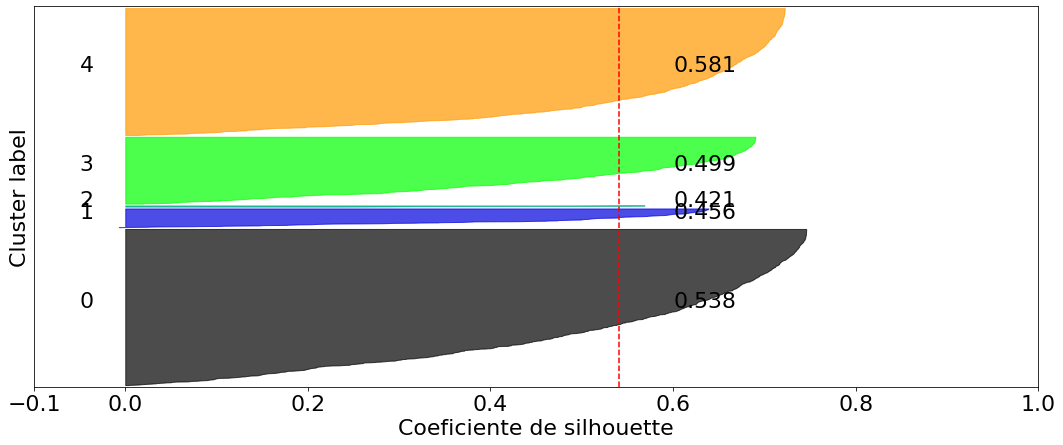

In [79]:
# Se grafican los coeficientes de silhouette obtenidos
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(audio_features) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Marcar los graficos de Silhouette con el numero de cluster
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Marcar los graficos de Silhouette con el Silhuette promedio del cluster
    ax1.text(0.6, y_lower + 0.5 * size_cluster_i, str(round(ith_cluster_silhouette_avg[i],3)))

    # Calcular donde comenzar el proximo grafixo
    y_lower = y_upper + 10 # Marco una distancia de 10 entre graficos para que haya un espacio

ax1.set_xlabel("Coeficiente de silhouette")
ax1.set_ylabel("Cluster label")

# La linea vertical es el Silhouette promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [80]:
audio_features_kmeans5.cluster_centers_

array([[ 4.33204279e-01,  4.59892374e-01,  3.05931436e+05,
         5.47247454e-01,  4.86618666e-01,  5.28786251e+00,
         1.90472180e-01, -1.16868894e+01,  5.38131042e-01,
         6.46323308e-02,  1.29084951e+02,  3.87218045e+00,
         3.32139635e-01],
       [ 7.13243036e-01,  2.96040179e-01,  7.33589911e+05,
         2.55785536e-01,  6.59682309e-01,  5.22321429e+00,
         1.84300000e-01, -1.87900982e+01,  6.07142857e-01,
         5.16714286e-02,  1.05558446e+02,  3.81250000e+00,
         2.03744643e-01],
       [ 7.55032500e-01,  2.07212500e-01,  1.58751825e+06,
         1.98936250e-01,  5.65298125e-01,  7.75000000e+00,
         2.88425000e-01, -2.05883750e+01,  8.75000000e-01,
         4.64000000e-02,  9.54225000e+01,  3.37500000e+00,
         5.25625000e-02],
       [ 5.66147240e-01,  3.93509774e-01,  4.53628373e+05,
         3.95305840e-01,  6.36905200e-01,  5.17794486e+00,
         1.66468170e-01, -1.53807218e+01,  5.16290727e-01,
         5.42827068e-02,  1.15902333e

In [81]:
d = euclidean_distances(audio_features, audio_features)

In [82]:
audio_features_kmeans5

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [83]:
# Creo que este es el valor de SSE
audio_features_kmeans5.inertia_

6990451230224.02

Ahora sí, se ejecutan distintas pruebas, iterando para distintos k.

In [84]:
kmax = 14
kmeans = []
sse = []
sil = []
for k in range(2, kmax + 1):
    km = KMeans(n_clusters = k, random_state = 0).fit(audio_features)
    kmeans.append(km)
    sil.append(silhouette_score(audio_features, km.labels_))
    sse.append(km.inertia_)    

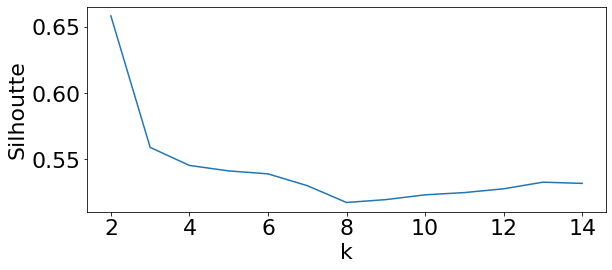

In [85]:
x = np.arange(2, kmax + 1)

# Se grafican los silhouttes
fig = pylab.figure()
axsil = fig.add_axes([0.05,0.05,0.9,0.475])
axsil.set_ylabel("Silhoutte")
axsil.set_xlabel("k")
plt.plot(x, sil)

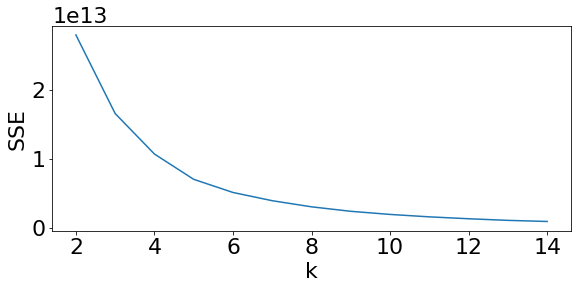

In [86]:
# Se grafican los SSE
fig = pylab.figure()
axsse = fig.add_axes([0.05,0.525,0.9,0.475])
axsse.set_ylabel("SSE")
axsse.set_xlabel("k")
plt.plot(x, sse)

¿Cuál sería el k ideal? El quiebre de SSE lo tenemos más o menos en 5 o en 6. Ya habíamos visto que en 5 el silhouette promedio obtenido es de 0.5412. Habría que probar qué pasa con 6. Ya con 7 y 8 el silhouette parece bajar demasiado y no obtenemos mucha ganancia en el SSE.

In [87]:
audio_features_kmeans6 = KMeans(n_clusters = 6, random_state = 0).fit(audio_features)
silhouette_avg = silhouette_score(audio_features, audio_features_kmeans6.labels_)
silhouette_avg

0.5389668044713934

In [88]:
# Se calcula el silhouette de cada observación
sample_silhouette_values = silhouette_samples(audio_features, audio_features_kmeans6.labels_)
sample_silhouette_values

array([0.42345435, 0.342571  , 0.70543506, ..., 0.22519525, 0.35719899,
       0.41300246])

In [90]:
# Se estima el coeficiente de Silhouette para cada cluster
cluster_labels = audio_features_kmeans6.labels_
n_clusters = len(np.unique(cluster_labels))
ith_cluster_silhouette_avg = []
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_avg.append(np.mean(ith_cluster_silhouette_values)) 
ith_cluster_silhouette_avg

[0.5367485279662224,
 0.5121598301449142,
 0.4706367063661181,
 0.5065635960609043,
 0.41313750801033944,
 0.5728335458801155]

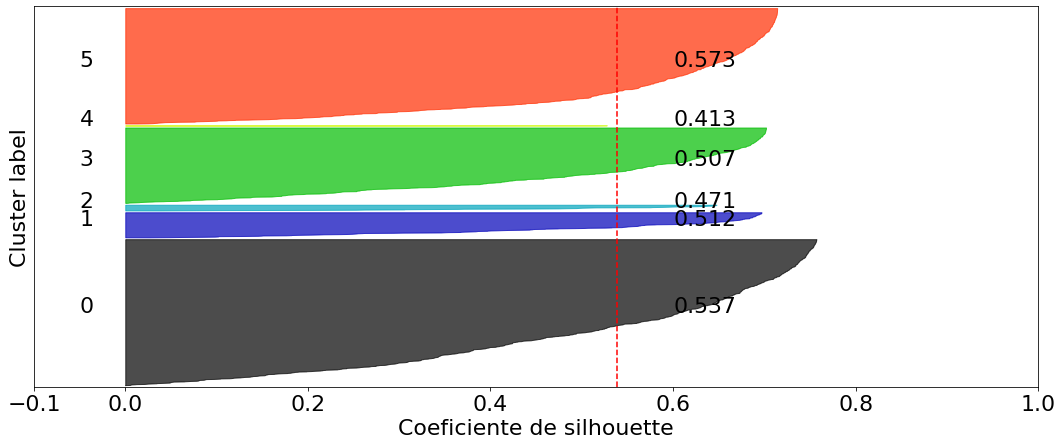

In [91]:
# Se grafican los coeficientes de silhouette obtenidos
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(audio_features) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Marcar los graficos de Silhouette con el numero de cluster
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Marcar los graficos de Silhouette con el Silhuette promedio del cluster
    ax1.text(0.6, y_lower + 0.5 * size_cluster_i, str(round(ith_cluster_silhouette_avg[i],3)))

    # Calcular donde comenzar el proximo grafixo
    y_lower = y_upper + 10 # Marco una distancia de 10 entre graficos para que haya un espacio

ax1.set_xlabel("Coeficiente de silhouette")
ax1.set_ylabel("Cluster label")

# La linea vertical es el Silhouette promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

TODO:
1) Encapsular en funciones para ejecutar lo mismo con los otros 2 datasets: audio_analysis y la fusión de ambos.
2) ¿Jugar con otro hyperparámetro además de k?